In [247]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# EDA

## questions

In [248]:
questions = pd.read_csv('questions_clean.csv', delimiter=',', encoding='utf-8')
"""
questions — база вопросов, для которой вы настраиваете поисковую систему
a) q_id — индивидуального номера каждого вопроса;
b) query — содержания вопроса.
"""
questions.head(10)

,q_id,query
0,1,Номер счета
1,2,Где узнать бик и счёт
2,3,Мне не приходят коды для подтверждения данной ...
3,4,"Оформила рассрочку ,но уведомлений никаких не ..."
4,5,"Здравствуйте, когда смогу пользоваться кредитн..."
5,6,По истории платеж не отображается
6,7,"Здравствуйте, в рп. Нахабино отделение банка н..."
7,8,Узнать зарплатный счет
8,9,"Подскажите, где я могу увидеть дату начала пол..."
9,10,Не приходит смс


In [249]:
# Проверил наличие пустых вопросов
questions.isna().sum()

q_id     0
query    0
dtype: int64

In [250]:
# Проверил наличие повторяющихся вопросов
(len(questions), len(questions.drop_duplicates()))

(6977, 6977)

## websites

In [251]:
websites = pd.read_csv('websites_updated.csv', delimiter=',', encoding='utf-8')
"""
websites — база знаний поисковой функции:
a) web_id — индивидуальный номер каждой веб страницы;
b) url — адрес веб-страницы;
c) kind — тип импортированных данных;
d) title — название страницы, ее заголовок;
e) text — колонка, содержащая заранее спарсенный со страницы текст.
"""
print(len(websites))
websites.head()

1938


,web_id,url,kind,title,text
0,1,https://alfabank.ru/,html,"Альфа-Банк - кредитные и дебетовые карты, кред...",Рассчитайте выгоду\nРасчёт калькулятора предва...
1,2,https://alfabank.ru/a-club/,html,А-Клуб. Деньги имеют значение,Брокерские услуги\nОткрытие брокерского счёта ...
2,3,https://alfabank.ru/a-club/ultimate/,html,А-Клуб. Деньги имеют значение,Хотите получить больше информации?\nПозвоните ...
3,4,https://alfabank.ru/actions/rules/,html,Скидки по картам,Правила проведения Акции «Альфа Пятница. Бараб...
4,5,https://alfabank.ru/alfafuture/,html,Альфа‑Будущее: Платформа для развития студенто...,Образование\nМагистратуры\nМагистратура ВШЭ\nМ...


In [252]:
# Посмотрел возможные варианты типа данных
websites['kind'].unique()

array(['html', 'document', nan], dtype=object)

In [253]:
# Изучил строку с nan - возможно, стоит удалить
websites[websites['kind'].isna()]

,web_id,url,kind,title,text
1937,1938,https://job.alfabank.ru/vacancies/moskva,NaN,NaN,NaN


In [254]:
# Изучил формат kind=document. Интересная колонка text по индексу 1877, 1882. Надо изучить на подобные
# Возможно нужен синтетичесий признак обработанное url + text
websites[websites['kind'] == 'document']

,web_id,url,kind,title,text
33,34,https://alfabank.servicecdn.ru/site-upload/5e/...,document,zalog_general_terms.pdf,АКЦИОНЕРНОЕ ОБЩЕСТВО «АЛЬФА-БАНК» \n\n (дале...
1487,1488,https://alfabank.st/site-upload/38/95/1784/Ref...,document,Refin-pamyatka-08022024.pdf,"___ \n\n107078, МОСКВА \n\nУЛ. КАЛАНЧЕВСКАЯ, 2..."
1703,1704,https://alfabank.servicecdn.ru/site-upload/e3/...,document,dogovor_cbo_1082025.pdf,Приложение к Распоряжению АО «АЛЬФА-БАНК» \nот...
1704,1705,https://alfabank.servicecdn.ru/site-upload/f4/...,document,dogovor_cbo_1072025.pdf,Приложение к Распоряжению АО «АЛЬФА-БАНК» \nот...
1705,1706,https://alfabank.servicecdn.ru/site-upload/c4/...,document,alfa_1082025.pdf,"Накопительный \nАльфа-Счёт\n\nДля счетов, откр..."
...,...,...,...,...,...
1877,1878,https://www.alfabank.by/upload/docs/bank/liche...,document,lichenzia.pdf,
1878,1879,https://www.alfabank.by/upload/docs/bank/polit...,document,polit-obr-file-cookie.pdf,...
1879,1880,https://www.alfabank.by/upload/docs/bank/polit...,document,polit-obr-pers-dan.pdf,УТВЕРЖДЕНО \n\nПротокол Правления Банка \n\n17...
1880,1881,https://www.alfabank.by/upload/docs/bank/polit...,document,politika-obrabotki-pd-v-processe-work.pdf,Отдел мониторинга и контроля обработки УТВЕР...


<Axes: xlabel='kind', ylabel='count'>

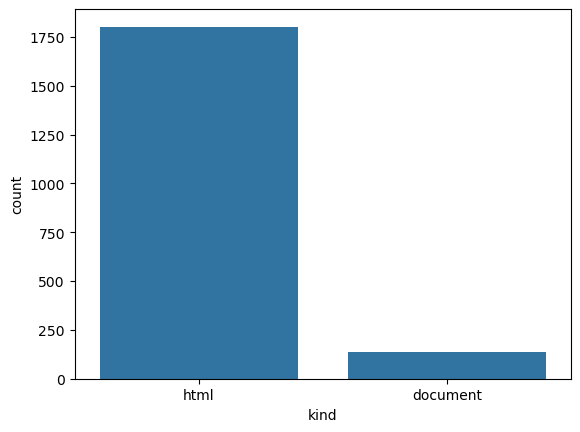

In [255]:
sns.countplot(websites, x='kind')

# Преобразовываем датафреймы

In [256]:
import re
import string

import nltk
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub('\d+', '', text)  # Удаление цифр
    text = re.sub(f'[{string.punctuation}]', '', text)  # Удаление пунктуации
    text = re.sub('—«»—', '', text) # Удаление символов', которые не попал в пунктуацию
    text = re.sub('\n', ' ', text)  # Удаление переносов строк
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Удаление стоп-слов
    return text

#nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Temp\ipykernel_12264\1276480762.py:9: SyntaxWarning: invalid escape sequence '\d'
  text = re.sub('\d+', '', text)  # Удаление цифр


## questions

In [257]:
questions.head()

,q_id,query
0,1,Номер счета
1,2,Где узнать бик и счёт
2,3,Мне не приходят коды для подтверждения данной ...
3,4,"Оформила рассрочку ,но уведомлений никаких не ..."
4,5,"Здравствуйте, когда смогу пользоваться кредитн..."


In [258]:
questions['query_transformed'] = questions['query'].apply(clean_text)
questions['query_transformed'] # Пустых строк нет

0                                             номер счета
1                                         узнать бик счёт
2             приходят коды подтверждения данной операции
3           оформила рассрочку уведомлений никаких пришло
4        здравствуйте смогу пользоваться кредитной картой
                              ...                        
6972    здравствуйте оплатил вчера жкх кэшбек начислен...
6973                здравствуйте заказать реквизиты банка
6974    здравствуйте подскажите пожалуйста могу посмот...
6975                        реквизиты оплаты номера карты
6976           отключить автопополнение брокерского счёта
Name: query_transformed, Length: 6977, dtype: object

## websites

In [259]:
websites.head()

,web_id,url,kind,title,text
0,1,https://alfabank.ru/,html,"Альфа-Банк - кредитные и дебетовые карты, кред...",Рассчитайте выгоду\nРасчёт калькулятора предва...
1,2,https://alfabank.ru/a-club/,html,А-Клуб. Деньги имеют значение,Брокерские услуги\nОткрытие брокерского счёта ...
2,3,https://alfabank.ru/a-club/ultimate/,html,А-Клуб. Деньги имеют значение,Хотите получить больше информации?\nПозвоните ...
3,4,https://alfabank.ru/actions/rules/,html,Скидки по картам,Правила проведения Акции «Альфа Пятница. Бараб...
4,5,https://alfabank.ru/alfafuture/,html,Альфа‑Будущее: Платформа для развития студенто...,Образование\nМагистратуры\nМагистратура ВШЭ\nМ...


In [260]:
# Удаляем строку с NaN
websites = websites.drop(index=1937, axis=0)

In [261]:
# Преобразовываем заголовок сайта
websites['title_transformed'] = websites['title'].apply(clean_text)

# Преобразовываем текст с сайта
websites['text_transformed'] = websites['text'].apply(clean_text)

websites

,web_id,url,kind,title,text,title_transformed,text_transformed
0,1,https://alfabank.ru/,html,"Альфа-Банк - кредитные и дебетовые карты, кред...",Рассчитайте выгоду\nРасчёт калькулятора предва...,альфабанк кредитные дебетовые карты кредиты на...,рассчитайте выгоду расчёт калькулятора предвар...
1,2,https://alfabank.ru/a-club/,html,А-Клуб. Деньги имеют значение,Брокерские услуги\nОткрытие брокерского счёта ...,аклуб деньги имеют значение,брокерские услуги открытие брокерского счёта п...
2,3,https://alfabank.ru/a-club/ultimate/,html,А-Клуб. Деньги имеют значение,Хотите получить больше информации?\nПозвоните ...,аклуб деньги имеют значение,хотите получить информации позвоните нам ответ...
3,4,https://alfabank.ru/actions/rules/,html,Скидки по картам,Правила проведения Акции «Альфа Пятница. Бараб...,скидки картам,правила проведения акции «альфа пятница бараба...
4,5,https://alfabank.ru/alfafuture/,html,Альфа‑Будущее: Платформа для развития студенто...,Образование\nМагистратуры\nМагистратура ВШЭ\nМ...,альфа‑будущее платформа развития студентов уни...,образование магистратуры магистратура вшэ маги...
...,...,...,...,...,...,...,...
1932,1933,https://alfabank.ru/get-money/land/credit-holi...,html,Кредитные каникулы — Альфа-Банк,Кредитные каникулы — это возможность временно ...,кредитные каникулы — альфабанк,кредитные каникулы — это возможность временно ...
1933,1934,https://alfabank.ru/help/t/retail/alfaforbusin...,html,Как вернуть деньги покупателю и как рассчитыва...,Возврат денег покупателю можно оформить через ...,вернуть деньги покупателю рассчитывается комис...,возврат денег покупателю оформить терминал опл...
1934,1935,https://alfabank.ru/help/articles/investments/...,html,Как вывести деньги с брокерского счёта — Альфа...,Вывести деньги с брокерского счёта можно на ка...,вывести деньги брокерского счёта — альфабанк,вывести деньги брокерского счёта карту банковс...
1935,1936,https://alfabank.ru/make-money/investments/hel...,html,Пополнение и вывод средств — Альфа-Инвестиции,Вывести деньги с брокерского счёта можно на сл...,пополнение вывод средств — альфаинвестиции,вывести деньги брокерского счёта следующий раб...


In [262]:
websites['url'].explode().tolist()

['https://alfabank.ru/',
 'https://alfabank.ru/a-club/',
 'https://alfabank.ru/a-club/ultimate/',
 'https://alfabank.ru/actions/rules/',
 'https://alfabank.ru/alfafuture/',
 'https://alfabank.ru/alfafuture/blog/alfabank-luchshiy-bank-dlya-starta-karery/',
 'https://alfabank.ru/alfafuture/blog/alfatim-na-finopolis365/',
 'https://alfabank.ru/alfafuture/blog/kak-dostich-karernogo-uspeha/?oirutpspid=1755624534531_49424a8cdc47a5a7803de7613c1c302e_4isaaskwnkrjib24&oirutpspsc=1755624559216_a3dd5ca5f2fd7135eec0863d0714980f_ux4GUPXCZyHjlxm8UvGZ0LV9VPUWGWRV6syNuJH.kKcZ&oirutpspjs=1755624559216_332557de_0135006b_c3f55d32767f0861c6d1cf5f4bcb4b66_ccEphYS4QJ1sMQfCLpcNHouUxkKh9O%2BfCntn07Y3L0G0jZU8HXTZsHB5l%2B4uJ1py8quDfyisRALudzx4CviXEbA0z1l6XsKj43dohCE9dQ3d4cwFFnqiC0tnbvcnC3N4mLyhBRHl7boqvgTRotdOC37q1wNsddjBJK1ByJ0BKWa2%2F5IOP4OuskdeWbitbMMw4YDNKbpuVqISJprrOwoiPIyw%2BCSlnKHoeAFqs%2FMaN3qIYIhWZ%2BLPisfPJlriZ%2BlNP0ojx%2BYy3ms63wHdK6VdIHBdxKkbcnuR895Gim50ngXRs3ppL3zFgWfFHoxaD9cU97OKnnKNlbvZpEgl9Ukw%

In [266]:
all_tags_list = []

def url_splitting(column):
    website_parts = list(column.split('/'))[3:]
    return [part for part in website_parts if len(part) > 5 and len(part) < 50 and part[0] != '2']

websites['tags_eng'] = websites['url'].apply(url_splitting)
websites

,web_id,url,kind,title,text,title_transformed,text_transformed,tags_eng
0,1,https://alfabank.ru/,html,"Альфа-Банк - кредитные и дебетовые карты, кред...",Рассчитайте выгоду\nРасчёт калькулятора предва...,альфабанк кредитные дебетовые карты кредиты на...,рассчитайте выгоду расчёт калькулятора предвар...,[]
1,2,https://alfabank.ru/a-club/,html,А-Клуб. Деньги имеют значение,Брокерские услуги\nОткрытие брокерского счёта ...,аклуб деньги имеют значение,брокерские услуги открытие брокерского счёта п...,[a-club]
2,3,https://alfabank.ru/a-club/ultimate/,html,А-Клуб. Деньги имеют значение,Хотите получить больше информации?\nПозвоните ...,аклуб деньги имеют значение,хотите получить информации позвоните нам ответ...,"[a-club, ultimate]"
3,4,https://alfabank.ru/actions/rules/,html,Скидки по картам,Правила проведения Акции «Альфа Пятница. Бараб...,скидки картам,правила проведения акции «альфа пятница бараба...,[actions]
4,5,https://alfabank.ru/alfafuture/,html,Альфа‑Будущее: Платформа для развития студенто...,Образование\nМагистратуры\nМагистратура ВШЭ\nМ...,альфа‑будущее платформа развития студентов уни...,образование магистратуры магистратура вшэ маги...,[alfafuture]
...,...,...,...,...,...,...,...,...
1932,1933,https://alfabank.ru/get-money/land/credit-holi...,html,Кредитные каникулы — Альфа-Банк,Кредитные каникулы — это возможность временно ...,кредитные каникулы — альфабанк,кредитные каникулы — это возможность временно ...,"[get-money, credit-holidays]"
1933,1934,https://alfabank.ru/help/t/retail/alfaforbusin...,html,Как вернуть деньги покупателю и как рассчитыва...,Возврат денег покупателю можно оформить через ...,вернуть деньги покупателю рассчитывается комис...,возврат денег покупателю оформить терминал опл...,"[retail, alfaforbusiness, ekvairing-i-onlain-k..."
1934,1935,https://alfabank.ru/help/articles/investments/...,html,Как вывести деньги с брокерского счёта — Альфа...,Вывести деньги с брокерского счёта можно на ка...,вывести деньги брокерского счёта — альфабанк,вывести деньги брокерского счёта карту банковс...,"[articles, investments, kak-vyvodit-s-brokersk..."
1935,1936,https://alfabank.ru/make-money/investments/hel...,html,Пополнение и вывод средств — Альфа-Инвестиции,Вывести деньги с брокерского счёта можно на сл...,пополнение вывод средств — альфаинвестиции,вывести деньги брокерского счёта следующий раб...,"[make-money, investments, popolnenie-i-vyvod-s..."


In [ ]:
all_unique_tags = websites['tags_eng'].explode().unique().tolist()
all_unique_tags